# Project Tasks

In the first two assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should try both combining the profiles with activities and using each data type independently.
* Implement different models of your choice for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier to predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session.

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially at the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

## Mutational catalogs and activities - WGS data

In [3]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137


Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [4]:
## Activities:
PCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA,SP117556,0.963,985,0,0,0,922,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
PCAWG_wgs_act["Cancer Types"].value_counts()

Cancer Types
Liver-HCC              326
Prost-AdenoCA          286
Panc-AdenoCA           241
Breast-AdenoCA         198
CNS-Medullo            146
Kidney-RCC             144
Ovary-AdenoCA          113
Lymph-BNHL             107
Skin-Melanoma          107
Eso-AdenoCA             98
Lymph-CLL               95
CNS-PiloAstro           89
Panc-Endocrine          85
Stomach-AdenoCA         75
ColoRect-AdenoCA        60
Head-SCC                57
Myeloid-MPN             56
Uterus-AdenoCA          51
Lung-SCC                48
Thy-AdenoCA             48
Kidney-ChRCC            45
CNS-GBM                 41
Bone-Osteosarc          38
Lung-AdenoCA            38
Biliary-AdenoCA         35
Bladder-TCC             23
SoftTissue-Liposarc     19
CNS-Oligo               18
Cervix-SCC              18
Bone-Benign             16
SoftTissue-Leiomyo      15
Breast-LobularCA        13
Bone-Epith              11
Myeloid-AML             11
Myeloid-MDS              4
Breast-DCIS              3
Cervix-AdenoCA 

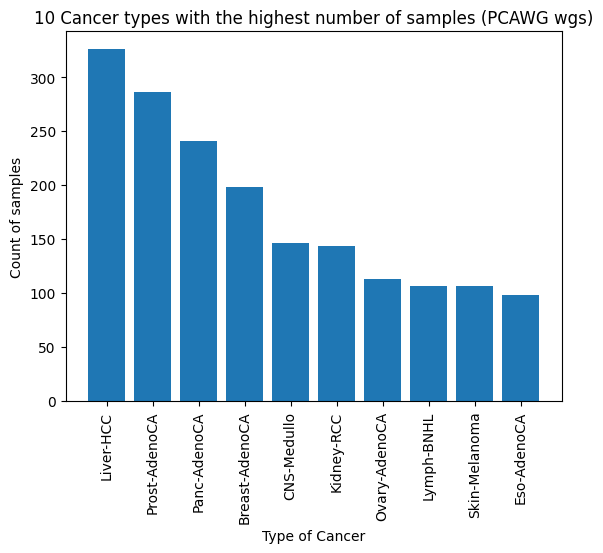

In [6]:
# added histogram for better visualization 
counts = PCAWG_wgs_act["Cancer Types"].value_counts().head(10)

plt.bar(counts.index, counts.values)
plt.xticks(rotation=90)
plt.xlabel("Type of Cancer")
plt.ylabel("Count of samples")
plt.title("10 Cancer types with the highest number of samples (PCAWG wgs)")
plt.show()

In [7]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,ALL::PD4020a,ALL::SJBALL011_D,ALL::SJBALL012_D,ALL::SJBALL020013_D1,ALL::SJBALL020422_D1,ALL::SJBALL020579_D1,ALL::SJBALL020589_D1,ALL::SJBALL020625_D1,...,Stomach-AdenoCa::pfg316T,Stomach-AdenoCa::pfg317T,Stomach-AdenoCa::pfg344T,Stomach-AdenoCa::pfg373T,Stomach-AdenoCa::pfg375T,Stomach-AdenoCa::pfg378T,Stomach-AdenoCa::pfg398T,Stomach-AdenoCa::pfg413T,Stomach-AdenoCa::pfg416T,Stomach-AdenoCa::pfg424T
0,C>A,ACA,35,9,2,7,5,7,3,5,...,133,185,202,185,96,134,12,279,75,135
1,C>A,ACC,16,2,4,10,5,9,1,2,...,48,70,126,88,35,54,16,112,31,91


In [8]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,PD4020a,0.995,208,3006,0,0,365,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALL,SJBALL011_D,0.905,66,0,0,0,144,0,0,...,0,0,0,0,0,0,0,0,0,0


## My attempt

In [9]:
# Keep the 96 channels as rows, samples as columns
meta_cols = ["Mutation type", "Trinucleotide"]
sample_cols = [c for c in PCAWG_wgs_mut.columns if c not in meta_cols]
channel_names = (PCAWG_wgs_mut["Mutation type"].astype(str) + "_" + PCAWG_wgs_mut["Trinucleotide"].astype(str)).tolist()

X_catalog = PCAWG_wgs_mut[sample_cols].to_numpy().T
X_catalog = pd.DataFrame(X_catalog, index=sample_cols, columns=channel_names)
X_catalog_norm = X_catalog.div(X_catalog.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0) # normalize
X_catalog_norm.head()

,C>A_ACA,C>A_ACC,C>A_ACG,C>A_ACT,C>A_CCA,C>A_CCC,C>A_CCG,C>A_CCT,C>A_GCA,C>A_GCC,...,T>G_CTG,T>G_CTT,T>G_GTA,T>G_GTC,T>G_GTG,T>G_GTT,T>G_TTA,T>G_TTC,T>G_TTG,T>G_TTT
Biliary-AdenoCA::SP117655,0.018054,0.009933,0.001678,0.010336,0.014430,0.009933,0.001812,0.012081,0.011074,0.005101,...,0.003289,0.017987,0.001275,0.001141,0.002886,0.005973,0.005570,0.003221,0.004228,0.013221
Biliary-AdenoCA::SP117556,0.022406,0.011006,0.002555,0.013758,0.012382,0.009631,0.001376,0.013561,0.015920,0.007272,...,0.004520,0.010417,0.001572,0.000983,0.003931,0.002948,0.005110,0.001965,0.006093,0.012579
Biliary-AdenoCA::SP117627,0.017728,0.011987,0.002195,0.012325,0.011987,0.009286,0.001351,0.010299,0.010299,0.008442,...,0.001351,0.007429,0.001182,0.001013,0.002364,0.002364,0.002701,0.001351,0.002533,0.008779
Biliary-AdenoCA::SP117775,0.017484,0.009911,0.002337,0.010152,0.010394,0.006607,0.002095,0.011522,0.013053,0.006768,...,0.003465,0.010636,0.001692,0.000564,0.002256,0.002740,0.003062,0.002417,0.004270,0.009830
Biliary-AdenoCA::SP117332,0.015046,0.010417,0.002315,0.008970,0.008681,0.006366,0.002894,0.010995,0.006076,0.007234,...,0.002315,0.005208,0.000579,0.001157,0.002025,0.002025,0.004340,0.002315,0.004630,0.010995


In [10]:
y = PCAWG_wgs_act["Cancer Types"].astype(str)
barcodes = PCAWG_wgs_act["Sample Names"].astype(str)
drop_cols = ["Cancer Types", "Sample Names"]
X_act = PCAWG_wgs_act.drop(columns=drop_cols)

# Optional: drop "Accuracy"? if We treat it as a QC/confounder rather than biological signal
if "Accuracy" in X_act.columns:
    X_act_noacc = X_act.drop(columns=["Accuracy"])
else:
    X_act_noacc = X_act

X_act_noacc.index = barcodes
y.index = barcodes
X_act_noacc.head()

,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
Sample Names,,,,,,,,,,,,,,,,,,,,,
SP117655,1496,1296,0,0,1825,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SP117556,985,0,0,0,922,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SP117627,1110,528,0,0,1453,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SP117775,1803,1271,0,0,2199,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SP117332,441,461,0,0,840,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
def extract_barcode(s):
    return s.split("::", 1)[-1]

X_catalog_norm = X_catalog_norm.copy()
X_catalog_norm["barcode"] = [extract_barcode(s) for s in X_catalog_norm.index]
X_catalog_norm = X_catalog_norm.set_index("barcode")

# Intersect
common = X_catalog_norm.index.intersection(X_act_noacc.index)

Xc = X_catalog_norm.loc[common]
Xa = X_act_noacc.loc[common]
y_common = y.loc[common]

print(Xc.shape, Xa.shape, y_common.shape)

(2780, 96) (2780, 65) (2780,)


In [12]:
X_combined = pd.concat([Xc, Xa], axis=1)
X_combined.head()

,C>A_ACA,C>A_ACC,C>A_ACG,C>A_ACT,C>A_CCA,C>A_CCC,C>A_CCG,C>A_CCT,C>A_GCA,C>A_GCC,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
SP117655,0.018054,0.009933,0.001678,0.010336,0.014430,0.009933,0.001812,0.012081,0.011074,0.005101,...,0,0,0,0,0,0,0,0,0,0
SP117556,0.022406,0.011006,0.002555,0.013758,0.012382,0.009631,0.001376,0.013561,0.015920,0.007272,...,0,0,0,0,0,0,0,0,0,0
SP117627,0.017728,0.011987,0.002195,0.012325,0.011987,0.009286,0.001351,0.010299,0.010299,0.008442,...,0,0,0,0,0,0,0,0,0,0
SP117775,0.017484,0.009911,0.002337,0.010152,0.010394,0.006607,0.002095,0.011522,0.013053,0.006768,...,0,0,0,0,0,0,0,0,0,0
SP117332,0.015046,0.010417,0.002315,0.008970,0.008681,0.006366,0.002894,0.010995,0.006076,0.007234,...,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn.model_selection import train_test_split

X = X_combined
X_train, X_test, y_train, y_test = train_test_split(
    X, y_common,
    test_size=0.2,
    random_state=0,
    stratify=y_common
)

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

models = {
    "logreg_l2": Pipeline([
        ("scaler", StandardScaler(with_mean=True)),
        ("clf", LogisticRegression(
            solver="saga",
            penalty="l2",
            max_iter=5000,
            n_jobs=-1
        ))
    ]),
    "linear_svm": Pipeline([
        ("scaler", StandardScaler(with_mean=True)),
        ("clf", LinearSVC(C=1.0))
    ]),
    "hgb": HistGradientBoostingClassifier(random_state=0)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_common))
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results[name] = {"cm": cm, "report": report}
    print("\n===", name, "===")
    print(classification_report(y_test, y_pred, zero_division=0))

/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)



=== logreg_l2 ===
                     precision    recall  f1-score   support

    Biliary-AdenoCA       0.00      0.00      0.00         7
        Bladder-TCC       1.00      0.40      0.57         5
        Bone-Benign       1.00      0.33      0.50         3
         Bone-Epith       0.50      0.50      0.50         2
     Bone-Osteosarc       0.50      0.50      0.50         8
     Breast-AdenoCA       0.62      0.67      0.64        39
        Breast-DCIS       0.00      0.00      0.00         1
   Breast-LobularCA       0.00      0.00      0.00         3
            CNS-GBM       0.70      0.88      0.78         8
        CNS-Medullo       0.74      0.90      0.81        29
          CNS-Oligo       1.00      0.25      0.40         4
      CNS-PiloAstro       0.75      0.50      0.60        18
         Cervix-SCC       0.67      0.50      0.57         4
   ColoRect-AdenoCA       0.82      0.75      0.78        12
        Eso-AdenoCA       0.68      0.65      0.67        20
    

/opt/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



=== linear_svm ===
                     precision    recall  f1-score   support

    Biliary-AdenoCA       0.00      0.00      0.00         7
        Bladder-TCC       0.75      0.60      0.67         5
        Bone-Benign       1.00      0.33      0.50         3
         Bone-Epith       0.33      0.50      0.40         2
     Bone-Osteosarc       0.43      0.38      0.40         8
     Breast-AdenoCA       0.70      0.72      0.71        39
        Breast-DCIS       0.00      0.00      0.00         1
   Breast-LobularCA       0.00      0.00      0.00         3
            CNS-GBM       0.78      0.88      0.82         8
        CNS-Medullo       0.73      0.83      0.77        29
          CNS-Oligo       1.00      0.25      0.40         4
      CNS-PiloAstro       0.33      0.11      0.17        18
         Cervix-SCC       0.25      0.50      0.33         4
   ColoRect-AdenoCA       0.69      0.75      0.72        12
        Eso-AdenoCA       0.70      0.70      0.70        20
   

/var/folders/jy/n18yqf_11rd2yfvwxqgqnv_80000gn/T/ipykernel_93130/3527030327.py:8: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1, keepdims=True)


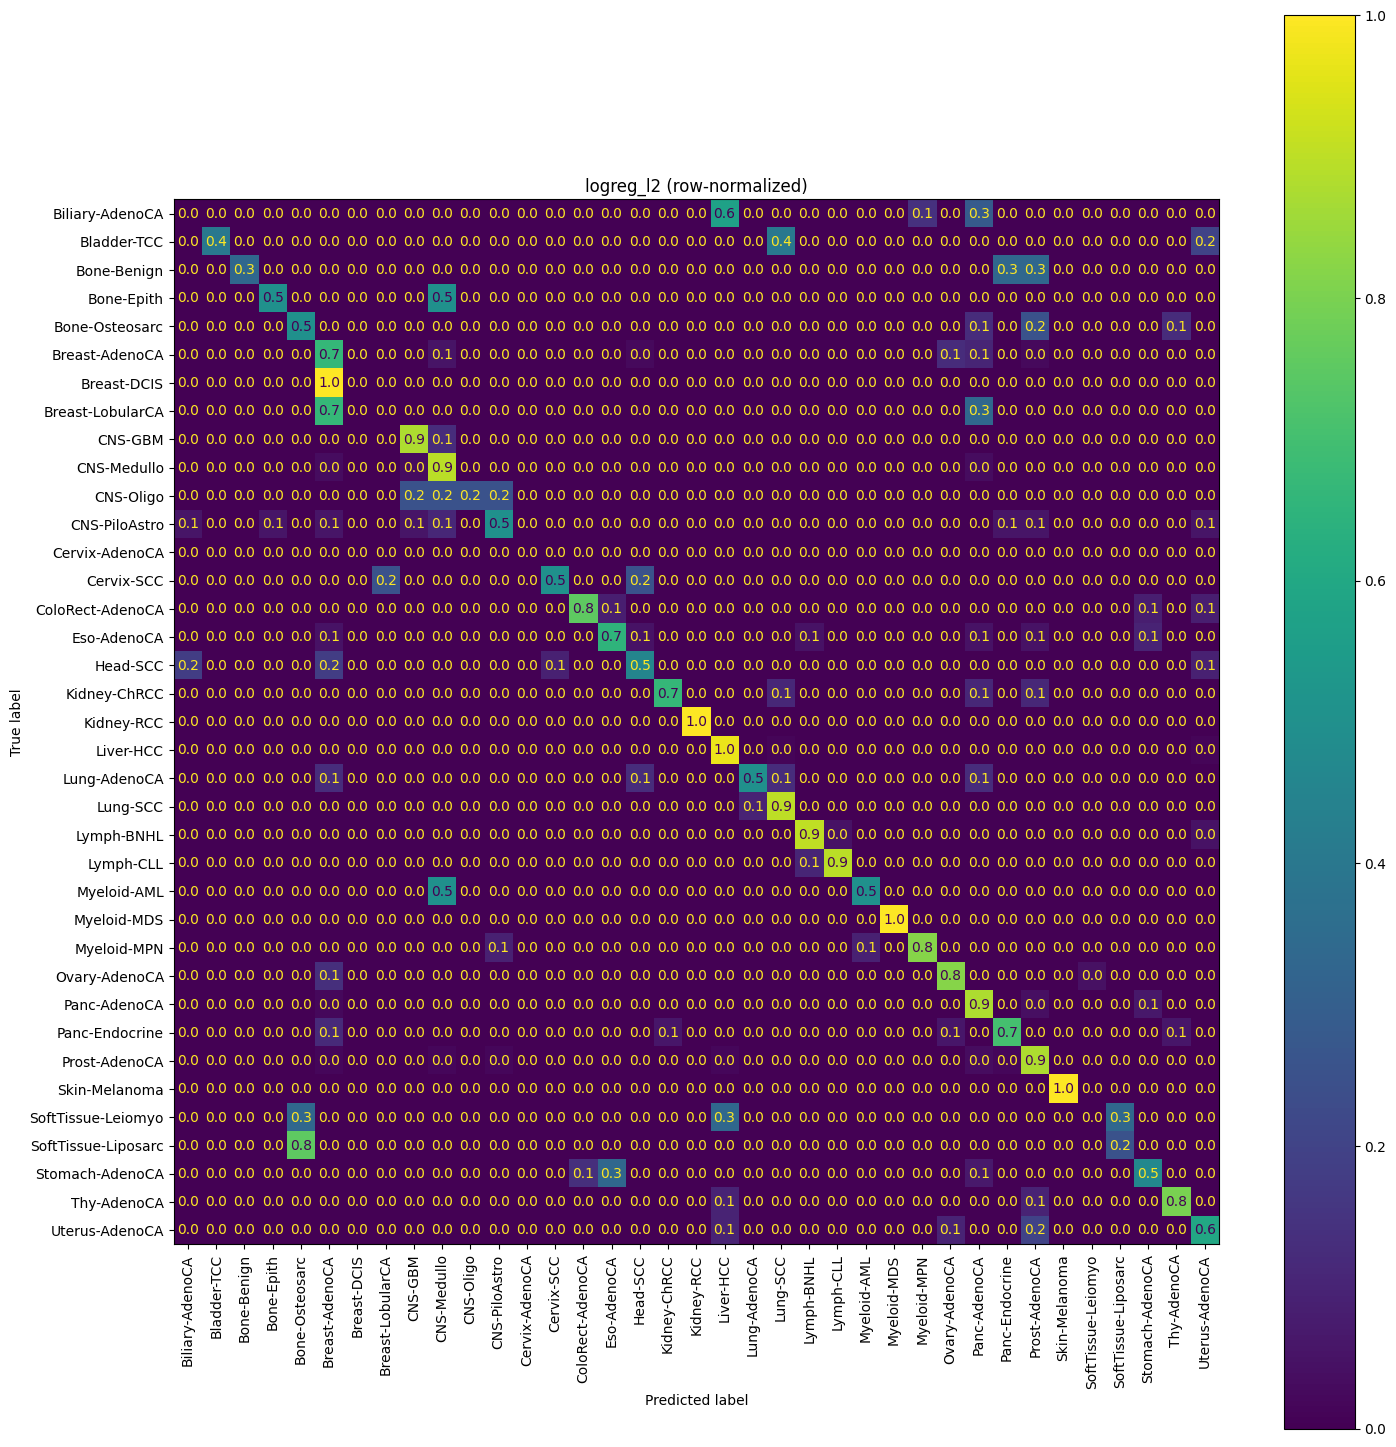

/var/folders/jy/n18yqf_11rd2yfvwxqgqnv_80000gn/T/ipykernel_93130/3527030327.py:8: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1, keepdims=True)


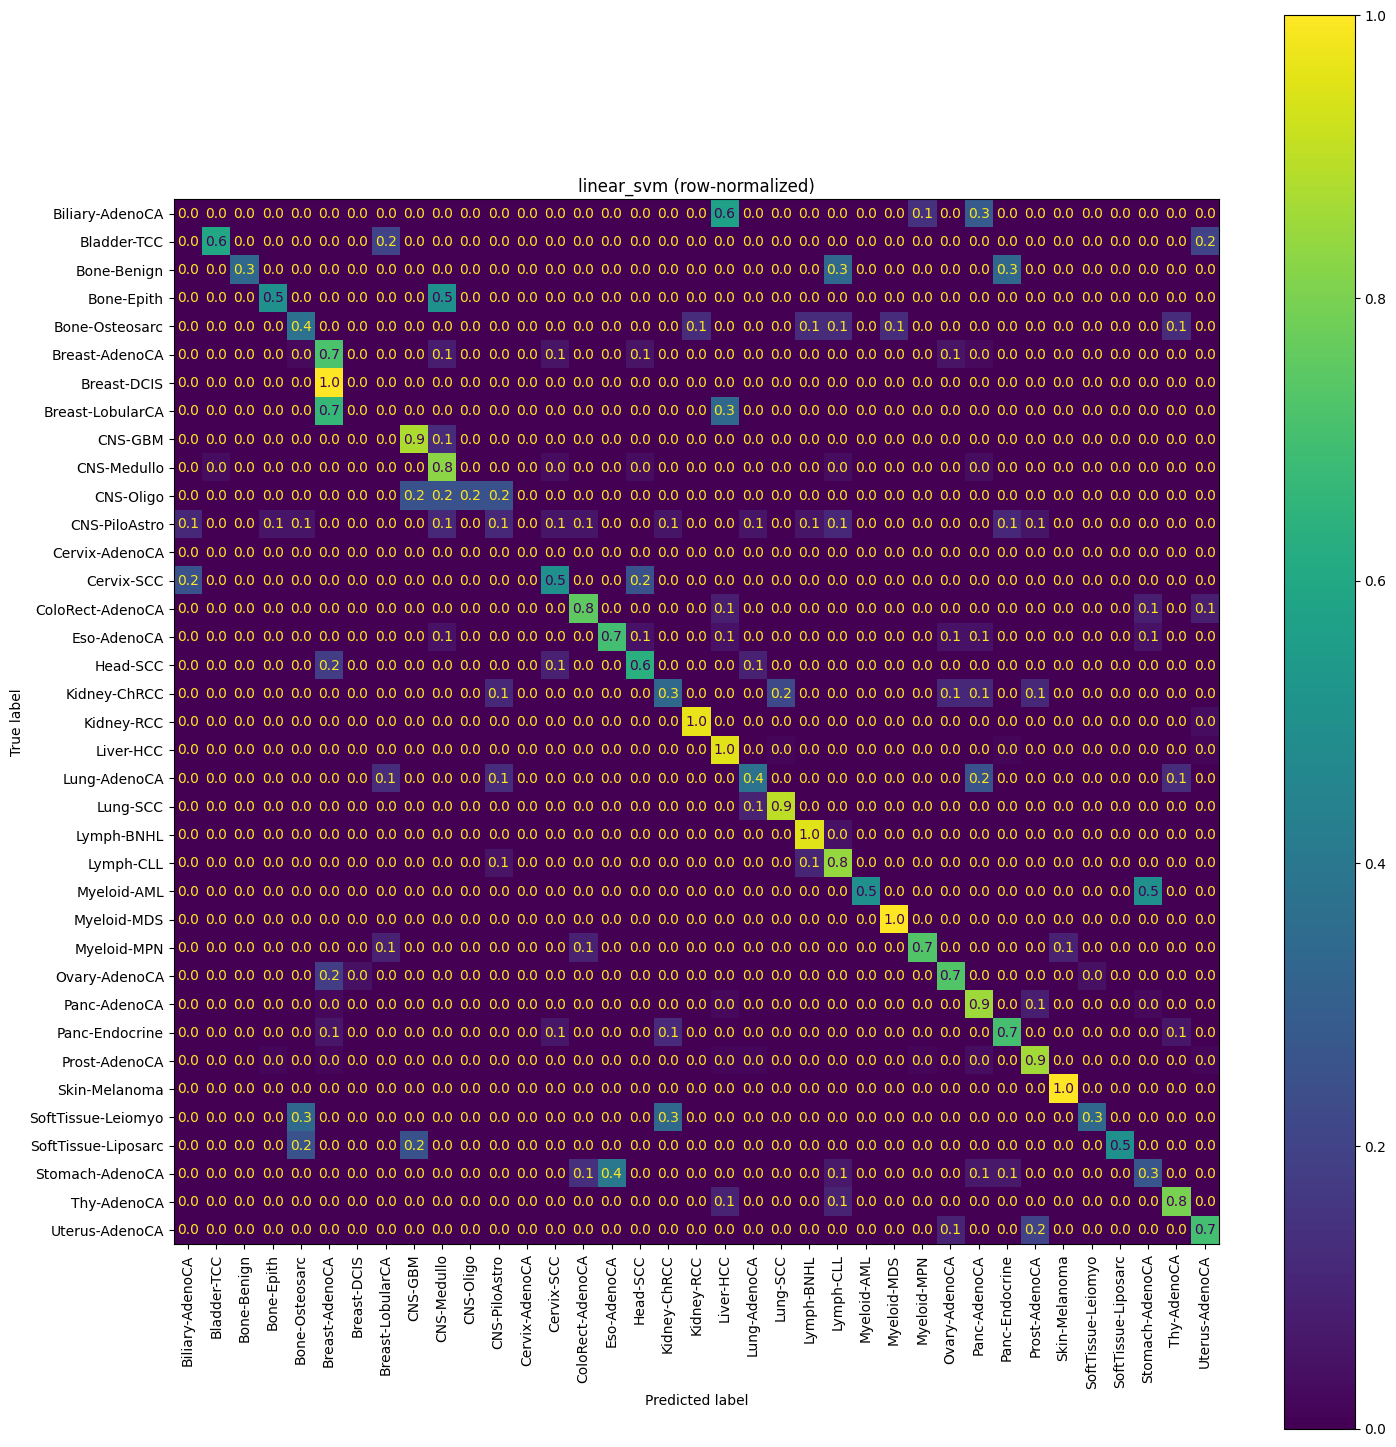

/var/folders/jy/n18yqf_11rd2yfvwxqgqnv_80000gn/T/ipykernel_93130/3527030327.py:8: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1, keepdims=True)


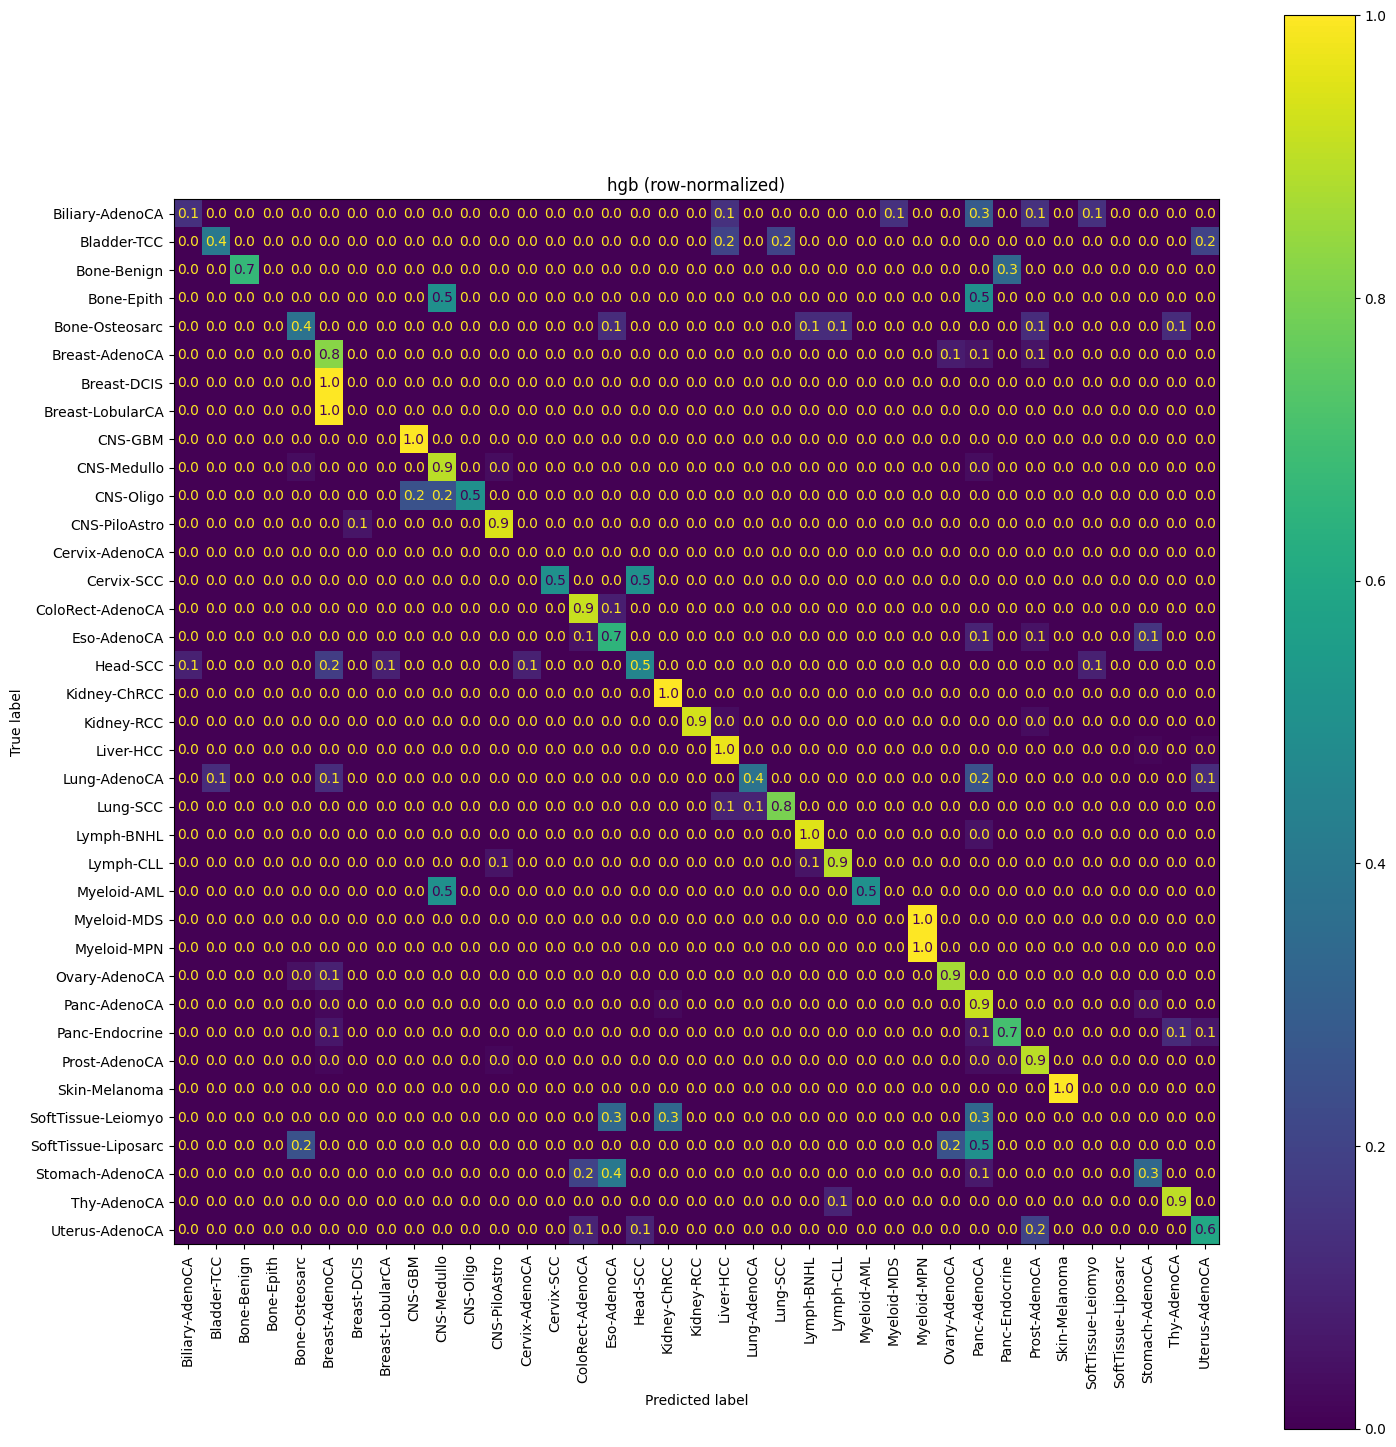

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = np.unique(y_common)

for name in models:
    cm = results[name]["cm"].astype(float)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm, nan=0.0)
    disp = ConfusionMatrixDisplay(cm_norm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(15, 15))
    disp.plot(ax=ax, xticks_rotation=90, values_format=".1f")  # or ".1%"
    ax.set_title(f"{name} (row-normalized)")
    plt.tight_layout()
    plt.show()

In [27]:
# Which features are informative? 
logreg = models["logreg_l2"].named_steps["clf"]
coef = logreg.coef_  # shape: n_classes x n_features
importance = np.linalg.norm(coef, axis=0)
imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
imp.head(10)

SBS40      4.368316
SBS1       3.258620
T>A_ATC    3.174444
C>A_TCC    3.064838
C>T_ACG    2.896028
C>G_CCG    2.867017
SBS3       2.847908
C>T_CCG    2.695427
SBS18      2.681804
T>C_TTC    2.677957
dtype: float64

In [28]:
logreg = models["linear_svm"].named_steps["clf"]
coef = logreg.coef_  # shape: n_classes x n_features
importance = np.linalg.norm(coef, axis=0)
imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
imp.head(10)

SBS36      4.021452
T>G_GTG    3.262229
SBS5       3.186850
SBS40      3.079814
C>T_ACG    2.723588
C>G_TCT    2.627982
SBS13      2.553105
C>T_CCG    2.513130
C>G_TCA    2.464596
SBS9       2.462493
dtype: float64